In [1]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

from abc import ABC, abstractmethod, abstractproperty

import numpy as np
import matplotlib.pyplot as plt

from wave import open as open_wave

In [24]:
class Wave:
    """ Discrete-time waveform. """
    def __init__(self, ys, ts=None, framerate=11025):
        """
        Inputs
        ------
        ys : array-like
            Wave array.
        ts : array-like
            Array of times.
        framerate : float (default: 11025)
            Samples per second.
        """
        self.ys = np.asarray(ys)
        self.framerate = framerate 
        if not ts is None:
            self.ts = np.asarray(ts)
        else:
            self.ts = np.arange(len(ys)) / self.framerate
            
    def __len__(self):
        return len(self.ys)
    
    @property
    def start(self):
        return self.ts[0]
    
    @property
    def end(self):
        return self.ts[-1]
    
    @property
    def duration(self):
        return len(self.ys) / self.framerate
    
    def _find_index(self, t):
        n     = len(self)
        start = self.start
        end   = self.end
        i     = round((n-1) * (t-start) / (end-start))
        return int(i)
    
    def _slice(self, i, j):
        ys = self.ys[i:j].copy()
        ts = self.ts[i:j].copy()
        return Wave(ys, ts, self.framerate)
        
    def segment(self, start=None, duration=None):
        i, j = 0, None
        if start is None:
            start = self.ts[0]
        else:
            i = self._find_index(start)
        if not duration is None:
            j = self._find_index(start + duration)
                        
        return self._slice(i, j)
    
    def normalize(self, amp=1.0):
        """
        Inputs
        ------
        amp : float
            Max amplitude (pos or neg) in result.
        """
        high, low = abs(max(self.ys)), abs(min(self.ys))
        self.ys = amp * self.ys / max(high, low)
    
    def quantize(self, bound, dtype):
        """ Quantize waveform. 

        Inputs
        ------- 
        bound: maximum amplitude       
        dtype: numpy data type of the result        

        returns: quantized signal        
        """
        if max(self.ys) > 1 or min(self.ys) < -1: 
            print("Normalizing before quantizing.")
            self.normalize(amp=1.0) 

        zs = (self.ys * bound).astype(dtype)  
        return zs 

In [41]:
class Signal(ABC):
    def __init__(self):
        super().__init__()
        
    def __add__(self, other):
        return SumSignal(self, other)
    __radd__ = __add__
    
    @abstractproperty
    def period(self):
        """ Period of singal in seconds.
        
            Default: return 0.1 seconds.
        """
        return 0.1
    
    @abstractmethod
    def evaluate(ts):
        #raise NotImplementedError()
        pass
    
    def make_wave(self, duration=1, start=0, framerate=11025):
        """ Make a wake object.
        
        Inputs
        -------
        duration : float (default: 1)
            Seconds
        start : float (default: 0)
            Seconds
        framerate : int (default: 11025)
            Frames per second.
        """
        n = round(duration + framerate)
        ts = start + np.arange(n) / framerate
        ys = self.evaluate(ts)
        return Wave(ys, ts, framerate=framerate)    

In [26]:
class SumSignal(Signal):              
    """Represents the sum of signals.
    
    Signals must be evaluated in a given context 
    (series of times) to have any meaning.
    """           
    def __init__(self, *args):        
        """
        Inputs
        -------
        args : tuple 
            Signals       
        """  
        self.signals = args
   
    @property       
    def period(self):  
        """Period of the signal in seconds. 
 
        This is only correct for a harmonic sequence where all 
        component frequencies are multiples of the fundamental. 

        Returns
        --------
        float 
            seconds 
        """ 
        return max(sig.period for sig in self.signals) 

    def evaluate(self, ts):                
        """Evaluates the signal at the given times.      
          
        Inputs
        ------
        ts : float 
            Array of times  
         
        Returns
        -------
        float 
            Wave array
        """      
        ts = np.asarray(ts)
        return sum(sig.evaluate(ts) for sig in self.signals)

In [27]:
class Sinusoid(Signal):
    def __init__(self, freq=440, amp=1.0, offset=0, func=np.sin):
        """
        Inputs
        ------
        freq : int (default: 440)
            Frequency in Hz
        amp : float (default: 1.0)
            Amplitude.
        offset : float (deafult: 0)
            Phase offset in radians.
        func : func (default: np.sin)
            Function that maps pahse to amlitude.
        """
        self.freq   = freq
        self.amp    = amp
        self.offset = offset
        self.func   = func
        
    @property
    def period(self):
        return 1.0 / self.freq
    
    def evaluate(self, ts):
        """
        Inputs
        ------
        ts : array-like
            Times.
        """
        phases = 2 * np.pi * self.freq * np.asarray(ts)
        phases += self.offset
        return self.amp * self.func(phases)

In [28]:
def CosSignal(freq=440, amp=1.0, offset=0):
    return Sinusoid(freq, amp, offset, func=np.cos)

def SinSignal(freq=440, amp=1.0, offset=0):
    return Sinusoid(freq, amp, offset, func=np.sin)

In [29]:
cos_sig = CosSignal(freq=440, amp=1.0, offset=0)
sin_sig = SinSignal(freq=880, amp=0.5, offset=0)

In [30]:
mix = cos_sig + sin_sig

In [31]:
def plot_wave(wave):
    plt.plot(wave.ts, wave.ys)
    plt.show();

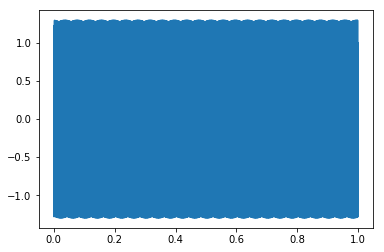

In [32]:
wave = mix.make_wave(duration=0.5, start=0, framerate=11025)
plot_wave(wave)

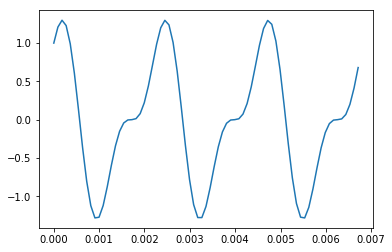

In [33]:
segment = wave.segment(start=0, duration=mix.period * 3)
plot_wave(segment)

In [34]:
class SilentSignal(Signal): 
    def evaluate(self, ts):
        return np.zeros(len(ts))

class WavFileWriter: 
    def __init__(self, filename="sound.wav", framerate=11025):                  
        """ Opens the file and sets parameters.
        
        Inputs
        -------
        filename  : string 
        framerate : int
            Samples per second.
        """ 
        self.filename  = filename 
        self.framerate = framerate 
        self.nchannels = 1 
        self.sampwidth = 2 
        self.bits = self.sampwidth * 8    
        self.bound = 2**(self.bits-1) - 1    
        
        self.fmt = 'h' 
        self.dtype = np.int16
        
        self.fp = open_wave(self.filename, 'w')
        self.fp.setnchannels(self.nchannels)
        self.fp.setsampwidth(self.sampwidth)
        self.fp.setframerate(self.framerate)
        
    def write(self, wave):  
        """ Writes a wave.
        
        Inputs
        -------
        wave : Wave      
        """   
        zs = wave.quantize(self.bound, self.dtype)                              
        self.fp.writeframes(zs.tostring())                                      
                                                                                
    def close(self, duration=0):                                                
        """Close wav file.
        
        Inputs
        -------
        duration : float
            How many seconds of silence to append.                         
        """  
        if duration:
            signal = SilentSignal()
            wave = signal.make_wave(duration)
            self.write(wave) 

        self.fp.close()
        
def write_wave(wave, filename="sound.wav"):  
    """ Write a wave file.  
    
    Inputs
    -------
    filename : string 
    """ 
    print("Writing", filename) 
    wfile = WavFileWriter(filename, wave.framerate) 
    wfile.write(wave) 
    wfile.close()
    
def read_wave(filename="sound.wav"):                                            
    """ Read a wave from file.
    Inputs
    -------
    filename : string
  
    Returns
    -------
    Wave                                                               
    """    
    fp = open_wave(filename, "r") 

    nchannels = fp.getnchannels()      
    nframes   = fp.getnframes()
    sampwidth = fp.getsampwidth()
    framerate = fp.getframerate() 

    z_str = fp.readframes(nframes) 
 
    fp.close() 
      
    dtype_map = {1:np.int8, 2:np.int16, 3:"special", 4:np.int32}  
    if sampwidth not in dtype_map:    
        raise ValueError("sampwidth {} unknown".format(sampwidth))
                
    if sampwidth == 3:        
        xs = np.fromstring(z_str, dtype=np.int8).astype(np.int32) 
        ys = (xs[2::3] * 256 + xs[1::3]) * 256 + xs[0::3]      
    else:        
        ys = np.fromstring(z_str, dtype=dtype_map[sampwidth]) 

    # if it's in stereo, just pull out the first channel    
    if nchannels == 2:   
        ys = ys[::2]
 
    #ts = np.arange(len(ys)) / framerate
    wave = Wave(ys, framerate=framerate)
    wave.normalize()
    return wave 

In [35]:
write_wave(wave)

Writing sound.wav
Normalizing before quantizing.


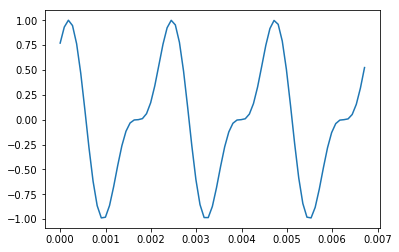

In [36]:
readed = read_wave()
readed = readed.segment(start=0, duration=mix.period * 3)
plot_wave(readed)

In [37]:
import subprocess

def play_wave(filename="sound.wav", player="aplay"):  
    cmd = "{} {}".format(player, filename)  
    popen = subprocess.Popen(cmd, shell=True)    
    popen.communicate()
    
play_wave()

In [38]:
play_wave(filename="violin-tuning.wav")

violin = read_wave(filename="violin-tuning.wav")
violin.normalize()

In [39]:
from IPython.display import Audio

Audio(data=violin.ys.real, rate=violin.framerate)

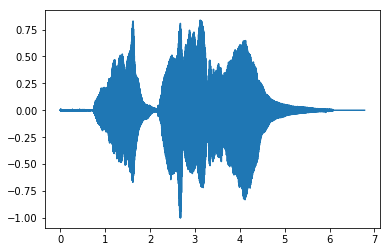

In [40]:
plot_wave(violin)

In [47]:
class SpectrumABC(ABC):
    def __init__(self, hs, fs, framerate, full=False):
        """
        Inputs
        -------
        hs : array-like
            Array of amplitudes (real or complex).
        fs : array-like
            Array of frequencies.
        framerate : float
            Frames per second.
        full : bool (default: False)
            Full or real FFT.
        """
        self.hs        = np.asarray(hs)
        self.fs        = np.asarray(fs)
        self.framerate = framerate
        self.full      = full
        
    @property
    def max_freq(self):
        """ Return Nyquist frequency for spectrum. """
        return self.framerate / 2.0
    
    @property
    def amps(self):
        """ Returns a sequence of amplitudes (read-only property). """
        return np.absolute(self.hs)
    
    @property
    def power(self):
        """ Returns a sequence of powers (read-only property). """
        return self.amps ** 2.0
    
    @property
    def freq_res(self):
        return self.framerate / 2 / (len(self.fs) -1)
        
class Spectrum(SpectrumABC):
    def __init__(self):
        super().__init__()
        
    def __len__(self):
        return len(self.hs)
    
    def __add__(self, other):
        assert(all(self.fs == other.fs))
        hs = self.hs + other.hs
        return Spectrum(hs, self.fs, self.framerate, self.full)